# Main Focus of the Notebook: Exploratory Data Analysis and Dropping detected spots which are most likely noise

In [1]:
from os import path
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import napari
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import zarr
import dask.array as da
import os 
sys.path.append('../src/')

from detections_preprocessing import hist_plot, box_whisker_plot

plt.rcParams["font.family"] = ""

### Do not change the code in the cell below 

In [2]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'test_data')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = 'datasets'
input_file_name = 'all_detections_channel3.pkl'
input_directory_full = os.path.join(base_dir,input_directory, input_file_name)

output_directory = 'datasets'
output_file_name = 'cleaned_spots_intensities_c3_all.pkl'
output_directory_full = os.path.join(base_dir,output_directory, output_file_name)

In [3]:
spots_df = pd.read_pickle(input_directory_full)

z2 = zarr.open(zarr_full_path, mode='r')
z2.shape

(130, 3, 75, 258, 275)

In [4]:
spots_df

,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame
0,206.593249,11.0,12.0,0.0,2.0,2.0,4.0,0
1,198.333333,69.0,52.0,-2.0,2.0,2.0,7.0,0
2,207.348417,103.0,123.0,4.0,3.0,2.0,36.0,0
3,185.333333,104.0,244.0,-2.0,4.0,2.0,7.0,0
4,191.000000,36.0,88.0,1.0,2.0,1.0,2.0,0
...,...,...,...,...,...,...,...,...
59173,179.531214,175.0,103.0,74.0,2.0,12.0,6.0,129
59174,261.261252,181.0,79.0,77.0,1.0,2.0,7.0,129
59175,350.231178,210.0,185.0,78.0,5.0,2.0,9.0,129
59176,211.258411,215.0,211.0,76.0,2.0,2.0,7.0,129


In [5]:
spots_df.shape

(59178, 8)

# Analysing Amplitude 
1. Box and Whisker Plot to find the upper and lower quartiles and caps 
2. Histogram to try and understand the distribution of the amplitude 

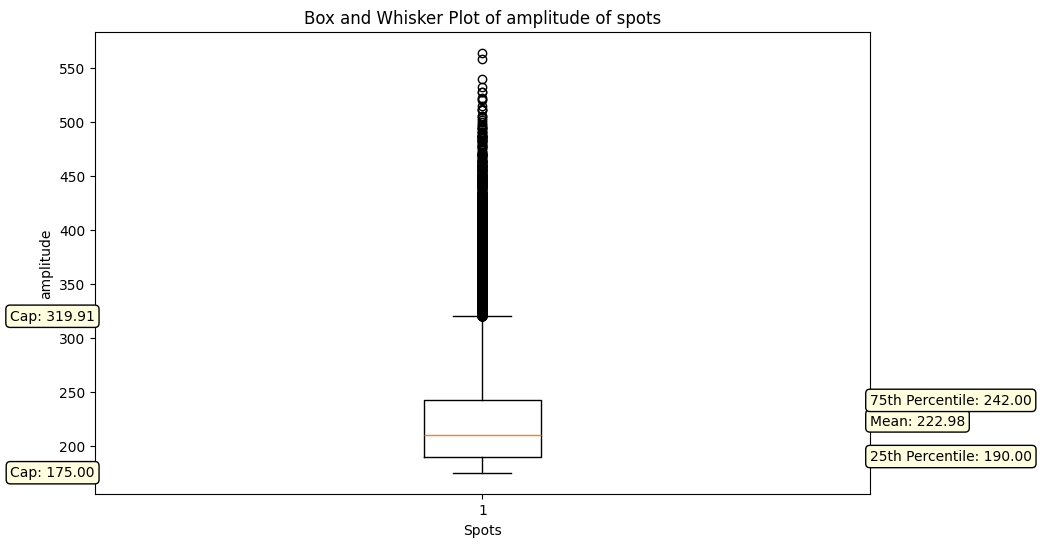

In [6]:
stats = box_whisker_plot(dataframe = spots_df,column_name = 'amplitude')

In [7]:
print(stats.keys())

dict_keys(['lower_whisker', 'upper_whisker', 'mean', 'lower_quantile', 'upper_quantile'])


In [8]:
amplitude_upper_whisker = stats['upper_whisker']
print(f'The upper whisker for amplitude is at {amplitude_upper_whisker}')
amplitude_lower_whisker = stats['lower_whisker']
print(f'The upper whisker for amplitude is at {amplitude_lower_whisker}')

The upper whisker for amplitude is at 319.9118486205657
The upper whisker for amplitude is at 175.00000000000003


In [9]:
print(len(spots_df[spots_df['amplitude'] > stats['upper_whisker']]))

2514


**Use the below dataframe for visualisation in napari and determine the final cuttoff**

In [10]:
high_amplitude_df = spots_df[spots_df['amplitude'] > stats['upper_whisker']].sort_values(by = 'amplitude', ascending = False)
high_amplitude_df.head()

,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame
4270,564.000000,202.0,229.0,56.0,1.0,1.0,2.0,7
1014,558.000000,223.0,95.0,60.0,1.0,1.0,2.0,1
1098,539.472079,136.0,152.0,72.0,2.0,2.0,2.0,1
25299,532.666667,122.0,177.0,65.0,0.0,2.0,1.0,48
3868,528.000000,198.0,182.0,76.0,2.0,1.0,5.0,6


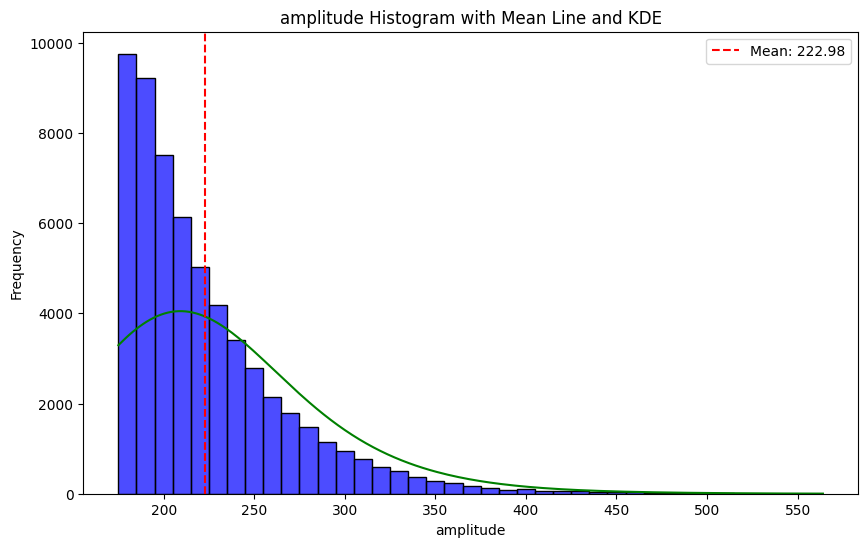

{'max_val': 564, 'min_val': 175, 'bin_size': 10}

In [11]:
hist_plot(dataframe = spots_df, column_name = 'amplitude', bin_size = 10)

# Analysing Std Dev of X
1. Box and Whisker Plot to find the upper and lower quartiles and caps 
2. Histogram to try and understand the distribution of the sigma_x

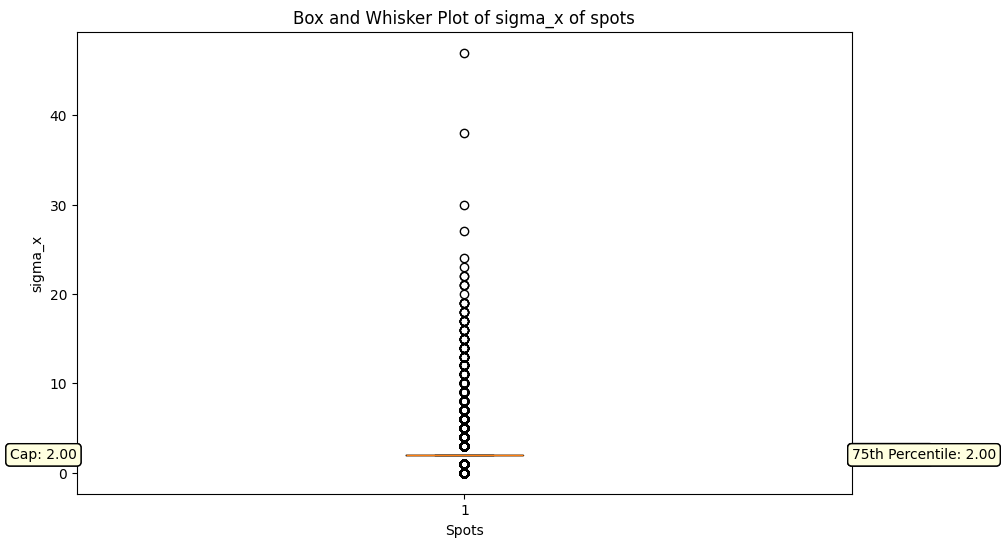

In [12]:
stats_sigma_x = box_whisker_plot(dataframe = spots_df,column_name = 'sigma_x')

In [13]:
print(stats_sigma_x.keys())

dict_keys(['lower_whisker', 'upper_whisker', 'mean', 'lower_quantile', 'upper_quantile'])


In [14]:
sigmax_upper_whisker = stats_sigma_x['upper_whisker']
sigmax_lower_whisker = stats_sigma_x['lower_whisker']

print(f'The upper whisker for sigma x is {sigmax_upper_whisker}')
print(f'The lower whisker for sigma x is {sigmax_lower_whisker}')

The upper whisker for sigma x is 2.0
The lower whisker for sigma x is 2.0


In [15]:
print(stats_sigma_x.values())

dict_values([2.0, 2.0, 2.0161546520666462, 2.0, 2.0])


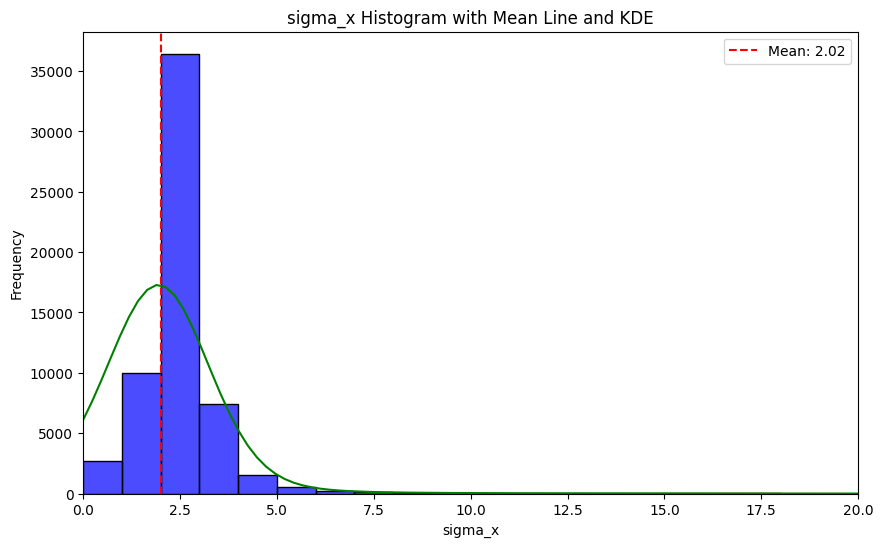

{'max_val': 47, 'min_val': 0, 'bin_size': 1}

In [16]:
hist_plot(dataframe = spots_df, column_name = 'sigma_x', bin_size = 1, custom_xaxis = True, 
          lower_xlimit = 0, upper_xlimit = 20)

In [17]:
high_sigmax_df = spots_df[spots_df['sigma_x'] > sigmax_upper_whisker].sort_values(by = 'sigma_x', ascending = False)
high_sigmax_df.head()

,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame
31632,184.009140,195.0,190.0,31.0,47.0,2.0,4.0,62
45993,203.126035,104.0,244.0,35.0,38.0,2.0,3.0,95
29633,226.381945,112.0,146.0,2.0,30.0,1.0,3.0,58
49500,199.616651,234.0,33.0,65.0,27.0,2.0,4.0,103
23473,199.379734,114.0,133.0,1.0,24.0,2.0,2.0,45


In [18]:
high_sigmax_df.shape

(10101, 8)

In [19]:
low_sigmax_df = spots_df[spots_df['sigma_x'] <= sigmax_lower_whisker].sort_values(by = 'sigma_x', ascending = False)
low_sigmax_df.head()

,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame
0,206.593249,11.0,12.0,0.0,2.0,2.0,4.0,0
36572,193.000000,107.0,193.0,30.0,2.0,1.0,3.0,73
36578,192.000000,181.0,124.0,32.0,2.0,2.0,4.0,73
36579,213.333333,185.0,202.0,27.0,2.0,2.0,9.0,73
36580,204.550838,100.0,118.0,32.0,2.0,1.0,4.0,73


In [20]:
low_sigmax_df.shape

(49077, 8)

# NOTES FOR SIGMA_X
# Two cases for sigma_x need to be tackled
1. **Spots with standard deviation of more than upper whisker**
2. **Spots with standard deviation of less than lower whisker**

# Analysing Std Dev of Y
1. Box and Whisker Plot to find the upper and lower quartiles and caps 
2. Histogram to try and understand the distribution of the sigma_y

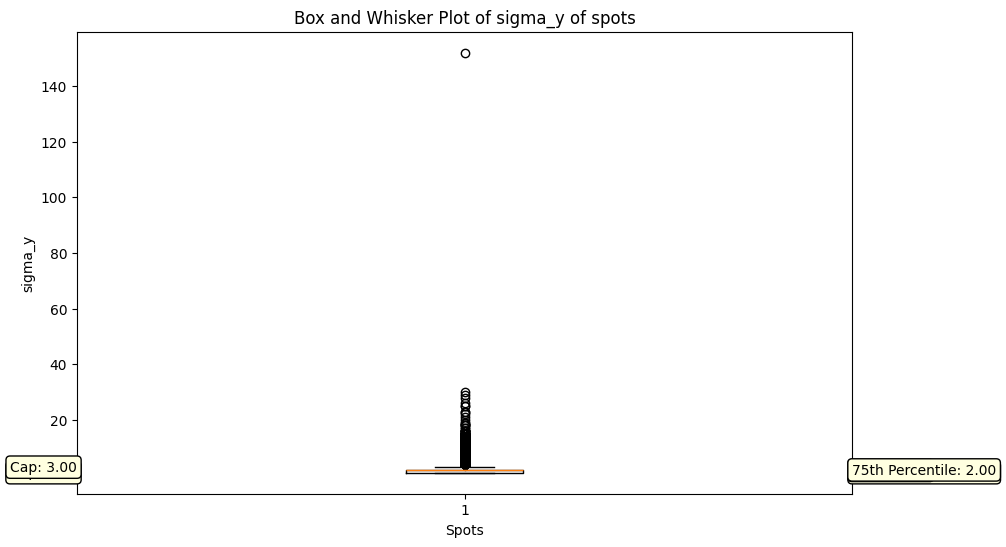

In [21]:
stats_sigma_y = box_whisker_plot(dataframe = spots_df,column_name = 'sigma_y')

In [22]:
print(stats_sigma_y)

{'lower_whisker': 1.0, 'upper_whisker': 3.0, 'mean': 1.824157626144851, 'lower_quantile': 1.0, 'upper_quantile': 2.0}


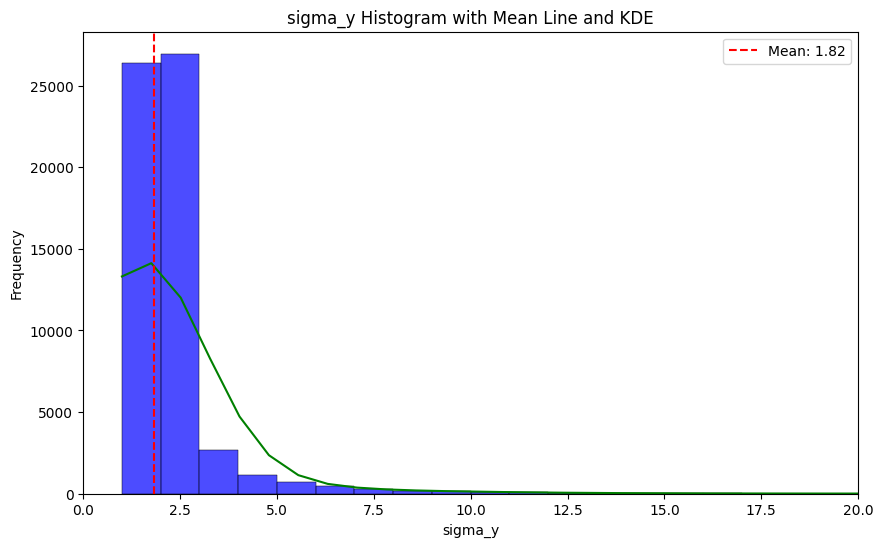

{'max_val': 152, 'min_val': 1, 'bin_size': 1}

In [23]:
hist_plot(dataframe = spots_df, column_name = 'sigma_y', bin_size = 1, custom_xaxis = True, 
          lower_xlimit = 0, upper_xlimit = 20)

In [24]:
sigmay_upper_whisker = stats_sigma_y['upper_whisker']
sigmay_lower_whisker = stats_sigma_y['lower_whisker']

print(f'The upper whisker for sigma y is {sigmay_upper_whisker}')
print(f'The lower whisker for sigma y is {sigmay_lower_whisker}')

The upper whisker for sigma y is 3.0
The lower whisker for sigma y is 1.0


In [25]:
high_sigmay_df = spots_df[spots_df['sigma_y']>sigmay_upper_whisker].sort_values(by='sigma_y', ascending = False)
high_sigmay_df.head()

,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame
6893,197.333333,81.0,56.0,40.0,0.0,152.0,2.0,12
57229,190.632666,122.0,199.0,32.0,2.0,30.0,4.0,124
11287,296.000000,231.0,149.0,70.0,2.0,29.0,4.0,20
20918,180.333333,117.0,76.0,62.0,0.0,28.0,1.0,39
138,221.333333,29.0,28.0,10.0,0.0,26.0,2.0,0


In [26]:
high_sigmay_df.shape

(3198, 8)

# Analysing Std Dev of Z
1. Box and Whisker Plot to find the upper and lower quartiles and caps 
2. Histogram to try and understand the distribution of the sigma_z

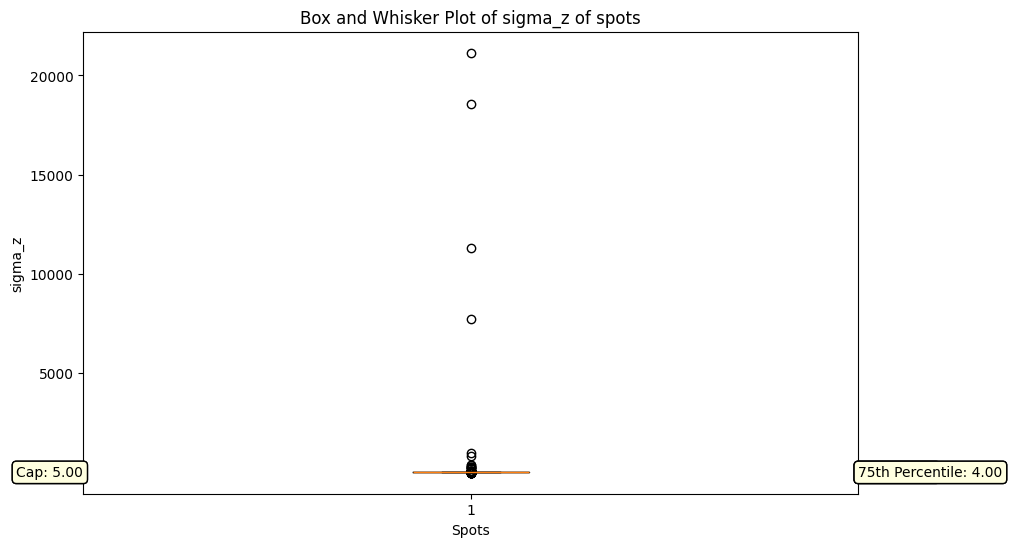

In [27]:
stats_sigma_z = box_whisker_plot(dataframe = spots_df,column_name = 'sigma_z')

In [28]:
print(stats_sigma_z)

{'lower_whisker': 2.0, 'upper_whisker': 5.0, 'mean': 4.7722464429348745, 'lower_quantile': 3.0, 'upper_quantile': 4.0}


In [29]:
sigmaz_upper_whisker = stats_sigma_z['upper_whisker']
sigmaz_lower_whisker = stats_sigma_z['lower_whisker']

print(f'The upper whisker for sigma z is {sigmaz_upper_whisker}')
print(f'The lower whisker for sigma z is {sigmaz_lower_whisker}')

The upper whisker for sigma z is 5.0
The lower whisker for sigma z is 2.0


In [30]:
print(len(spots_df[spots_df['sigma_z'] > sigmaz_upper_whisker]))

6718


In [31]:
high_sigmaz_df = spots_df[spots_df['sigma_z'] > sigmaz_upper_whisker]

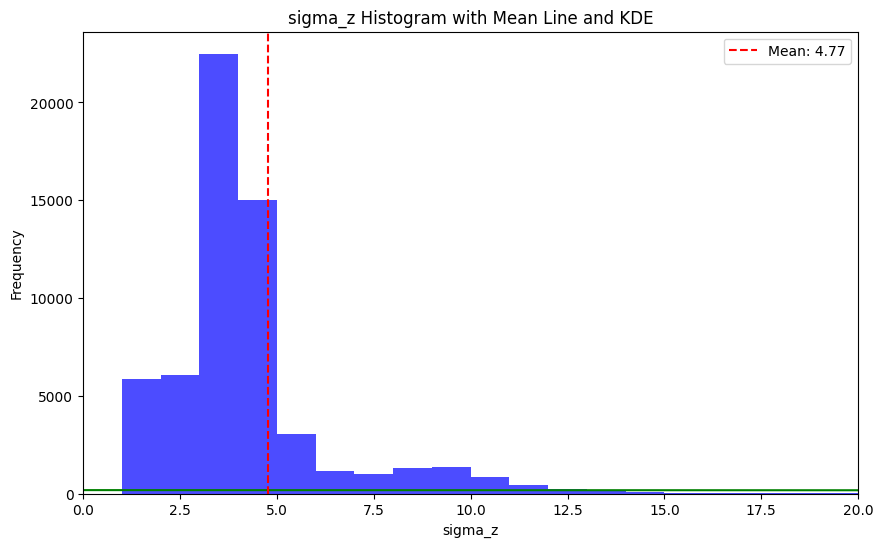

{'max_val': 21142, 'min_val': -13, 'bin_size': 1}

In [32]:
hist_plot(dataframe = spots_df, column_name = 'sigma_z', bin_size = 1,custom_xaxis = True, 
          lower_xlimit = 0, upper_xlimit = 20)

In [33]:
spots_df['sigma_z'].describe()

count    59178.000000
mean         4.772246
std        128.716229
min        -13.000000
25%          3.000000
50%          3.000000
75%          4.000000
max      21142.000000
Name: sigma_z, dtype: float64

In [34]:
spots_df['sigma_y'].describe()

count    59178.000000
mean         1.824158
std          1.467334
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max        152.000000
Name: sigma_y, dtype: float64

In [35]:
spots_df['sigma_x'].describe()

count    59178.000000
mean         2.016155
std          1.134533
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         47.000000
Name: sigma_x, dtype: float64

# NAPARI VISUALISATION

# HIGH AMPLITUDE POINTS VISUALISATION

In [36]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
#for the sake of improved performance only 1 channel could be imported here (if images get super large and performance issues occur)
all_channels = dask_array[:,:,:,:,:]

# Add the 4D stack to the viewer
layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['actin', 'dynamin', 'clathrin'])
#other useful parameters 
#color_map = list
#contrast_limits = list of list 

# Add Bounding Box
layer_raw[0].bounding_box.visible = True
layer_raw[1].bounding_box.visible = True
layer_raw[2].bounding_box.visible = True

In [37]:
points_layer = viewer.add_points(high_amplitude_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'High Amplitude Points', face_color = 'white', symbol = 'ring')

In [38]:
high_amplitude_df['amplitude'].min()

320.00000000000006

## High Sigma X points analysis in Napari

In [39]:
points_layer = viewer.add_points(high_sigmax_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'High Sigma X points', face_color = 'red', symbol = 'ring')

In [40]:
#high_sigmax_df.iloc[972]

In [41]:
points_layer = viewer.add_points(low_sigmax_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'Low Sigma X points', face_color = 'white', symbol = 'ring')

In [42]:
#low_sigmax_df.iloc[1906]

# Testing for Sigma y in napari

In [43]:
points_layer = viewer.add_points(high_sigmay_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'High Sigma Y points', face_color = 'white', symbol = 'ring')

# Testing for Sigma z in napari

In [44]:
points_layer = viewer.add_points(high_sigmaz_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'High Sigma Z points', face_color = 'white', symbol = 'ring')

In [45]:
#high_sigmaz_df.iloc[662]

# DROPPING VALUES OUTSIDE OF CUTOFF LIMITS

In [46]:
print(f'the upper whisker for amplitude is {amplitude_upper_whisker}')
print(f'the lower whisker for amplitude is {amplitude_lower_whisker}')
print(f'the upper whisker for sigma x is {sigmax_upper_whisker}')
print(f'the lower whisker for sigma x is {sigmax_lower_whisker}')
print(f'the upper whisker for sigma y is {sigmay_upper_whisker}')
print(f'the lower whisker for sigma y is {sigmay_lower_whisker}')
print(f'the upper whisker for sigma z is {sigmaz_upper_whisker}')
print(f'the lower whisker for sigma z is {sigmaz_lower_whisker}')

the upper whisker for amplitude is 319.9118486205657
the lower whisker for amplitude is 175.00000000000003
the upper whisker for sigma x is 2.0
the lower whisker for sigma x is 2.0
the upper whisker for sigma y is 3.0
the lower whisker for sigma y is 1.0
the upper whisker for sigma z is 5.0
the lower whisker for sigma z is 2.0


## The above values are used to determine the cutoff values 
## Selected Cut off Values are 
1. Amplitude is 350 
2. Sigma x upper bound is 4
3. Sigma y upper bound is 4
4. Sigma z upper bound is 6

In [47]:
# Define the conditions

# tolerance for limits 
tolerance = 1.0

#dropping spots above certain threshold 
condition_1 = spots_df['amplitude'] <= amplitude_upper_whisker + 31


#dropping spots above certain standard dev in x
condition_2 = spots_df['sigma_x'] <= sigmax_upper_whisker + 2


#dropping spots above certain standard dev in y 
condition_3 = spots_df['sigma_y'] <= sigmay_upper_whisker + 1


#dropping spots above certain standard dev in z
condition_4 = spots_df['sigma_z'] <= sigmaz_upper_whisker + 1 

#dropping spots below certain standard dev in x
condition_5 = spots_df['sigma_x'] >= sigmax_lower_whisker - 1

#dropping spots below certain standard dev in y
condition_6 = spots_df['sigma_y'] >= sigmay_lower_whisker 

#dropping spots below certain standard dev in z
condition_7 = spots_df['sigma_z'] >= sigmaz_lower_whisker 

#dropping spots out of bounds of z axis 
condition_8 = spots_df['mu_z'] >= 0
condition_9 = spots_df['mu_z'] <= z2.shape[2]

#dropping spots out of bounds of x axis 
condition_10 = spots_df['mu_x'] >= 0
condition_11 = spots_df['mu_x'] <= z2.shape[4]

#dropping spots out of bounds of y axis 
condition_12 = spots_df['mu_y'] >= 0
condition_13 = spots_df['mu_y'] <= z2.shape[3]


# Combine the conditions using logical AND (&)
cleaned_spots_df = spots_df[condition_1 & condition_2 & condition_3 & condition_4 & condition_5 & condition_6 &
condition_7 & condition_8 & condition_9 & condition_10 & condition_11 & condition_11 & condition_12 & condition_13].reset_index(drop = True)

# Display the resulting DataFrame
cleaned_spots_df

,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame
0,206.593249,11.0,12.0,0.0,2.0,2.0,4.0,0
1,191.000000,36.0,88.0,1.0,2.0,1.0,2.0,0
2,231.007679,40.0,141.0,1.0,2.0,2.0,2.0,0
3,185.152538,40.0,58.0,1.0,2.0,1.0,3.0,0
4,202.000000,46.0,73.0,1.0,2.0,2.0,3.0,0
...,...,...,...,...,...,...,...,...
43341,177.830039,160.0,133.0,72.0,2.0,2.0,3.0,129
43342,179.000000,201.0,207.0,71.0,2.0,1.0,3.0,129
43343,274.813463,219.0,45.0,71.0,2.0,2.0,2.0,129
43344,175.445348,231.0,219.0,71.0,3.0,2.0,2.0,129


In [48]:
dropped_spots = spots_df[~(condition_1 & condition_2 & condition_3 & condition_4 & condition_5 & condition_6 &
condition_7 & condition_8 & condition_9 & condition_10 & condition_11 & condition_11 & condition_12 & condition_13)]

In [49]:
cleaned_spots_df['mu_z'].min()

0.0

In [50]:
cleaned_spots_df.shape

(43346, 8)

In [51]:
#Visualising the dropped spots and the cleaned spots 
points_layer = viewer.add_points(dropped_spots[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'Dropped Spots', face_color = 'blue', symbol = 'ring')

points_layer = viewer.add_points(cleaned_spots_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'Cleaned Spots', face_color = 'red', symbol = 'ring')

# Final Graphs

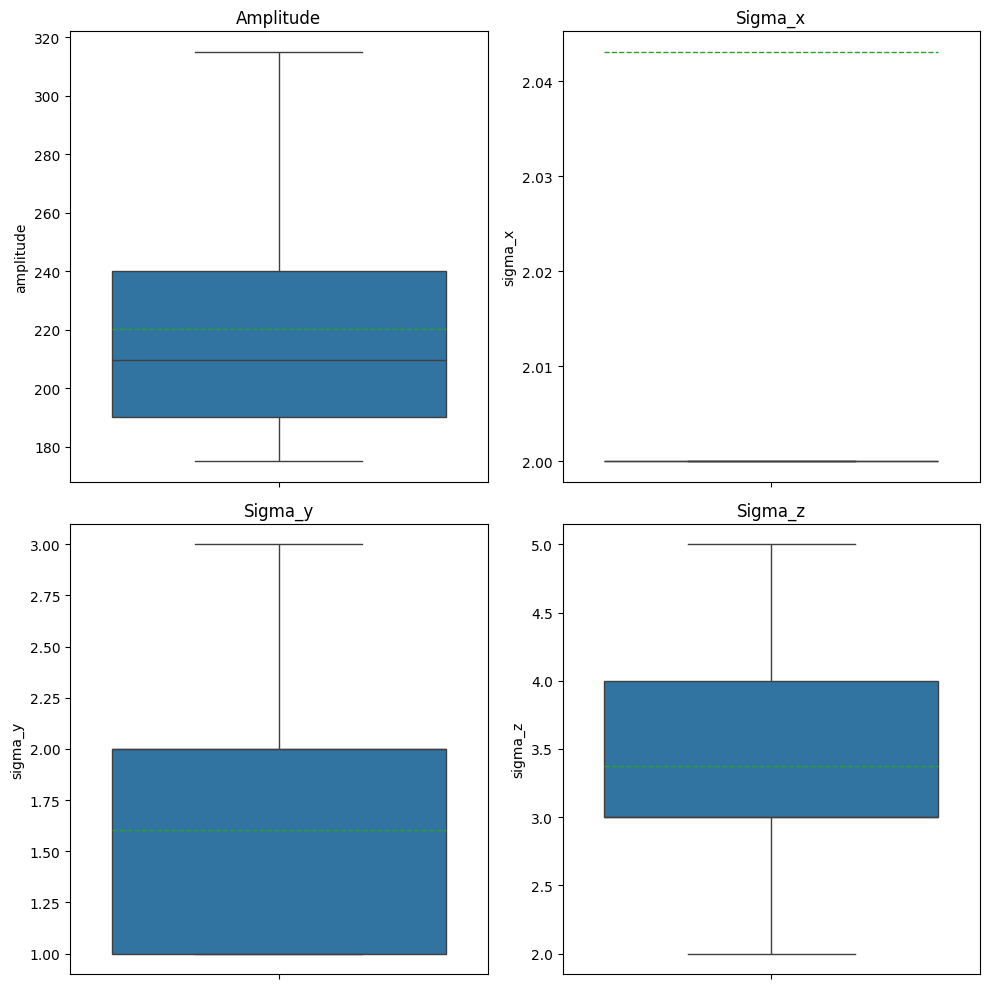

In [52]:
# Set up subplots as a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Box plot for Amplitude
sns.boxplot(y='amplitude', data=cleaned_spots_df, ax=axes[0], showmeans=True, meanline=True, showfliers=False)
axes[0].set_title('Amplitude')

# Box plot for sigma_x
sns.boxplot(y='sigma_x', data=cleaned_spots_df, ax=axes[1], showmeans=True, meanline=True, showfliers=False)
axes[1].set_title('Sigma_x')

# Box plot for sigma_y
sns.boxplot(y='sigma_y', data=cleaned_spots_df, ax=axes[2], showmeans=True, meanline=True, showfliers=False)
axes[2].set_title('Sigma_y')

# Box plot for sigma_z
sns.boxplot(y='sigma_z', data=cleaned_spots_df, ax=axes[3], showmeans=True, meanline=True, showfliers=False)
axes[3].set_title('Sigma_z')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


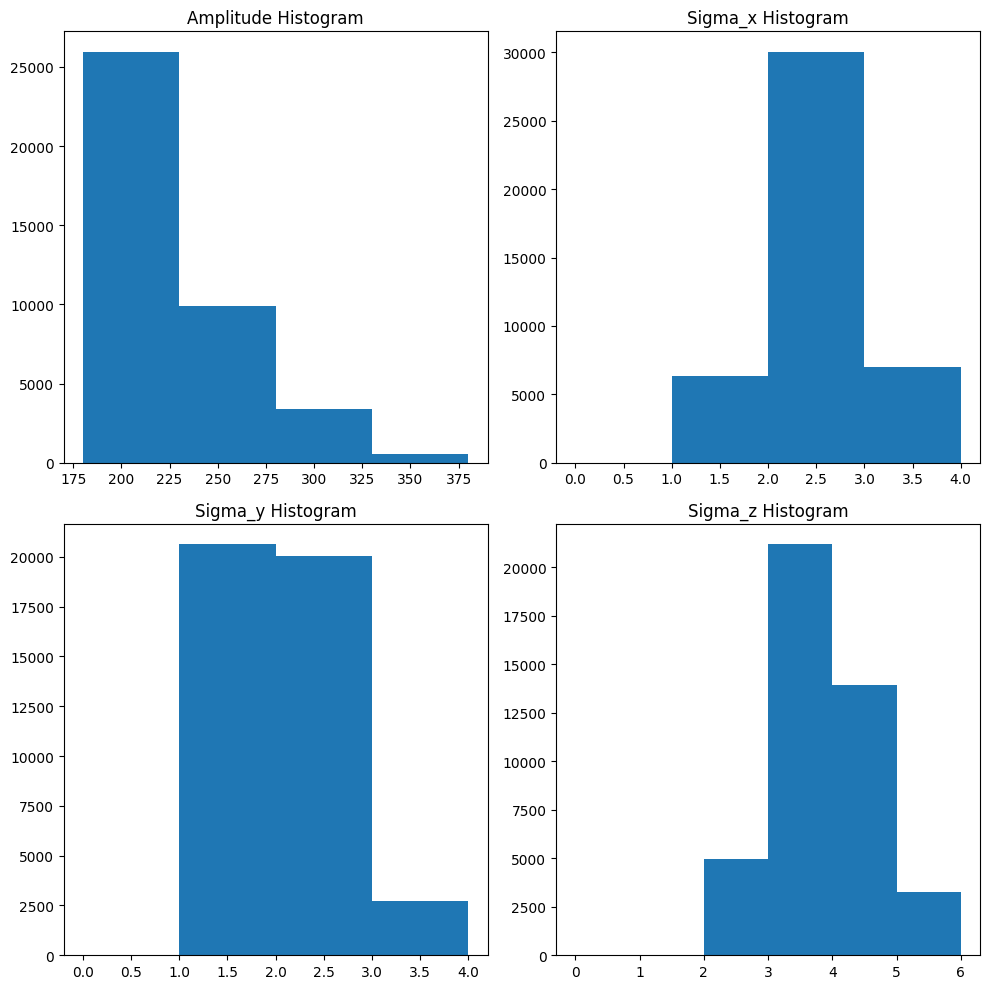

In [53]:
# Assuming cleaned_spots_df is your DataFrame with columns 'Amplitude', 'sigma_x', 'sigma_y', 'sigma_z'

# Set up subplots as a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Histogram for Amplitude with bins of size 50 starting from 180
axes[0].hist(cleaned_spots_df['amplitude'].dropna(), bins=range(180, int(cleaned_spots_df['amplitude'].max()) + 50, 50))
axes[0].set_title('Amplitude Histogram')

# Histogram for sigma_x with bins of size 1 starting from 0
axes[1].hist(cleaned_spots_df['sigma_x'].dropna(), bins=range(0, int(cleaned_spots_df['sigma_x'].max()) + 1, 1))
axes[1].set_title('Sigma_x Histogram')

# Histogram for sigma_y with bins of size 1 starting from 0
axes[2].hist(cleaned_spots_df['sigma_y'].dropna(), bins=range(0, int(cleaned_spots_df['sigma_y'].max()) + 1, 1))
axes[2].set_title('Sigma_y Histogram')

# Histogram for sigma_z with bins of size 1 starting from 0
axes[3].hist(cleaned_spots_df['sigma_z'].dropna(), bins=range(0, int(cleaned_spots_df['sigma_z'].max()) + 1, 1))
axes[3].set_title('Sigma_z Histogram')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


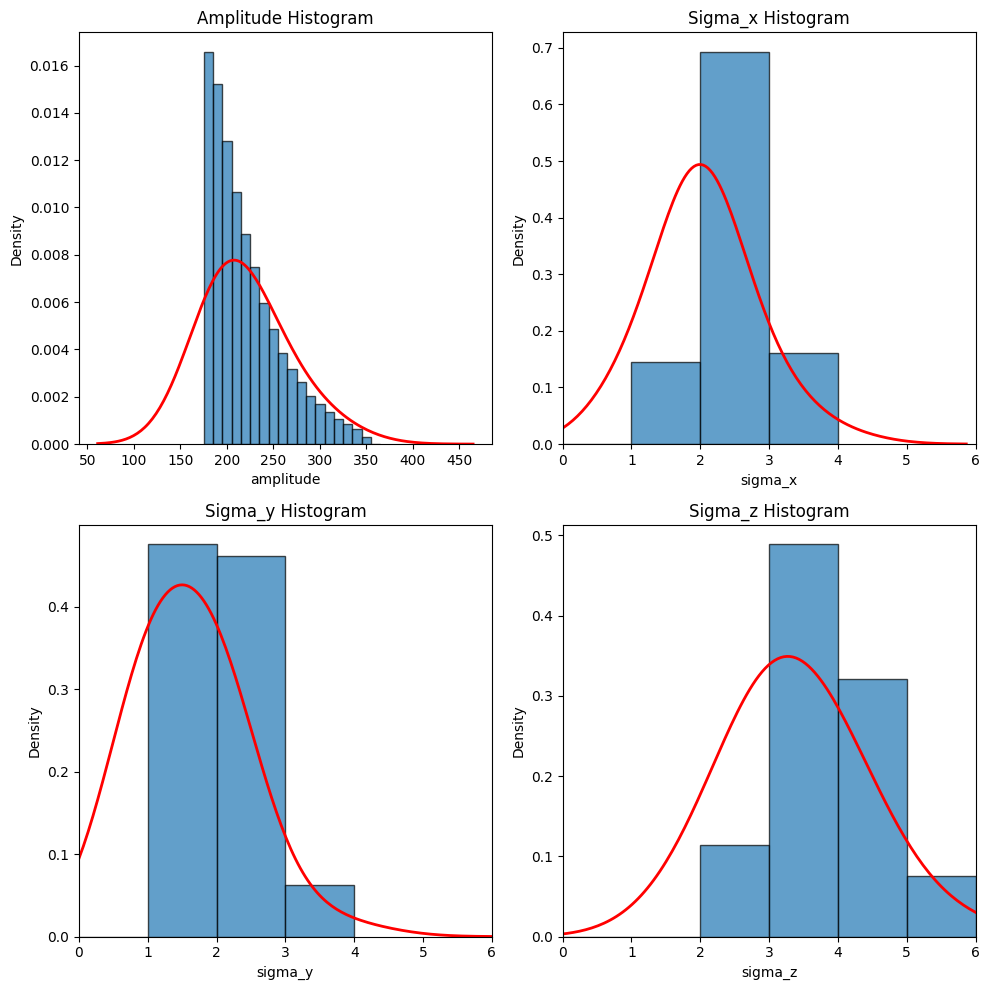

In [54]:
# Set up subplots as a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Histogram for Amplitude with bins of size 50 starting from 180
ax = axes[0].hist(cleaned_spots_df['amplitude'], bins=range(175,375,10), edgecolor='black', density = True,alpha=0.7)
sns.kdeplot(cleaned_spots_df['amplitude'], ax=axes[0], color='red', linewidth=2, bw_method=1)
axes[0].set_title('Amplitude Histogram')

# Histogram for sigma_x with bins of size 1 starting from 0
axes[1].hist(cleaned_spots_df['sigma_x'], bins=range(0, int(cleaned_spots_df['sigma_x'].max()) + 1, 1), 
              density = True, edgecolor='black', alpha=0.7)
sns.kdeplot(cleaned_spots_df['sigma_x'], ax=axes[1], color='red', linewidth=2, bw_method=1)
axes[1].set_title('Sigma_x Histogram')

# Histogram for sigma_y with bins of size 1 starting from 0
axes[2].hist(cleaned_spots_df['sigma_y'], bins=range(0, int(cleaned_spots_df['sigma_y'].max()) + 1, 1), 
             density=True, edgecolor='black', alpha=0.7)
sns.kdeplot(cleaned_spots_df['sigma_y'], ax=axes[2], color='red', linewidth=2, bw_method=1)
axes[2].set_title('Sigma_y Histogram')

# Histogram for sigma_z with bins of size 1 starting from 0
axes[3].hist(cleaned_spots_df['sigma_z'], bins=range(0, int(cleaned_spots_df['sigma_z'].max()) + 1, 1), 
             density=True, edgecolor='black', alpha=0.7)
sns.kdeplot(cleaned_spots_df['sigma_z'], ax=axes[3], color='red', linewidth=2, bw_method=1)
axes[3].set_title('Sigma_z Histogram')

# Set x-axis limit for sigma_z KDE plot
axes[1].set_xlim(0, cleaned_spots_df['sigma_z'].max())
axes[2].set_xlim(0, cleaned_spots_df['sigma_z'].max())
axes[3].set_xlim(0, cleaned_spots_df['sigma_z'].max())

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


In [55]:
# Save the DataFrame to a Pickle file
cleaned_spots_df.to_pickle(output_directory_full)